# Some uses for SVD

**Unsupervised learning: dimensionality reduction**

**Abstract:** Singular value decomposition (SVD) is referred to by many as kind of a linear algebra "Swiss army knife". The motivation for this notebook is to show that SVD can in fact find versitile applications in analytics. This notebook gives a short overview of what SVD is and demonstrates two uses for it, namely (1) solving the einproblem that comes with PCA and, (2) compressing, say, images. Be warned, the PCA part includes some mathematical explanations to connect some dots. If math notation doesn't really rock your boat, feel free to skip that part.

**Topics covered:** singular value decomp (SVD), principal component analysis (PCA), compression.

**So, what's SVD?** We can rewrite any real or complex matrix into the factor of three components. These components together is what we refer to as the _singular value_ of the matrix in question.

Take for instance the real-valued matrix $X \in \mathbb{R}^{n \times p}$ with $n$ rows and $p$ columns. Let $s$ be the smaller of two numbers, i.e. $s = \min(n, p)$. The SVD of $X$ is the factorization 

$$
X = U \cdot \Sigma \cdot V^T
$$

where $U \in \mathbb{R}^{n \times s}$, $\Sigma \in \mathbb{R}^{s \times s}$, and $V^T \in \mathbb{R}^{s \times p}$.

Let's unpack these three components.

$U$ and $V$ are both unitary matrices, meaning that their transpose are also their inverse. In other words, $U^T U = I$ and $V^T V = I$ where $I$ is the identity matrix. 

The columns of $U$ are known as the _left singular vectors_ and the rows of $V^T$ as the _right singular vectors_ of $X$. If we denote these vectors by $u_i$ and $v_i$, then

$$
\begin{array}{rcl}
  U & = & \begin{bmatrix} u_0 & u_1 & \cdots & u_{s-1} \end{bmatrix} \\
  V^T & = & \begin{bmatrix} v_0 & v_1 & \cdots & v_{s-1} \end{bmatrix}^T.
\end{array}
$$

$\Sigma$ is a diagonal matrix. Its diagonal entries are, collectively, called the _singular values_ of $X$, and are sorted from highest to lowest, i.e. $\sigma_0 >= \sigma_1 >= .... >= \sigma_{s-1}$

$$
\begin{equation}
\Sigma =
\begin{bmatrix}
  \sigma_0 &          &        & \\
           & \sigma_1 &        & \\
           &          & \ddots & \\
           &          &        & \sigma_{s-1}
\end{bmatrix}
\end{equation}.
$$

**Aha, so what?** From these definitions we imply that 

$$
X V = U \Sigma.
$$

This is a compact way of writing a system of independent vector equations, namely

$$
\begin{array}{rcl}
  X v_i & = & \sigma_i u_i.
\end{array}
$$

It kind of looks like an eigenproblem already, doesn't it?

**And... what's it good for?** Well: dimensionality reduction! We can use SVD to come up with a smaller representation of $X$ that still preserves its "mass". Two cool applications for it are:

* We can use the rows of $V^T$ (the right singular vectors) as a solution to the eigenproblem that comes with PCA.
* We can use the entries of $\Sigma$ (the singular values) for compressing, say, images. This provides us with a way of measuring the relative reconstruction error compared to the original image.

We'll demonstrate these two applications next.

# Demo No. 1: PCA

Principal component analysis lets us come up with a lower-dimensional, but equally informative representation of the data. Essentially we transform the data into orthogonal dimensions ranking them by variance. This is useful for visualization and discovering hidden structures in the data. Here an attempt to prove why we can use the rows of $V^T$ as the principal components (PCs).

(If you don't want to get into any "nasty" math, start to skip here).

In PCA we want to find the projection-maximizing set of axes. This computation can be reduced to an eigenproblem. We can use SVD to find the eigenpair(s) that solve the PCA eigenproblem.

The PCA cost function is

$$
\begin{array}{rcl}
  \underset{\varphi, \lambda}{\arg\max} \, \hat{F}(\varphi, \lambda)
  = F(\varphi) + \frac{\lambda}{2} (1 - \varphi^T \varphi)
\end{array}
$$

and $\varphi$ is the unit-length vector we use to project the centered data $X$. Computing the partial derivatives and solving this Lagrange objective function for $(\varphi^*, \lambda^*)$ yields

$$
\begin{array}{rcl}
  \frac{1}{m} X^T X \varphi & = & \lambda \varphi \\
  \| \varphi \|_2^2 & = & 1.
\end{array}
$$

Note that $\frac{1}{m} X^T X$ is nothing but the sample covariance matrix.

If we insert the SVD into the first equation above, we end up with something really neat, namely

$$
X^T X V = V \Sigma^2,
$$

or, as a system of vector equations,

$$
\begin{array}{rcl}
  X^T X v_i & = & \sigma_i^2 v_i.
\end{array}
$$

As we can see, $v_i$ is the eigenvector of the covariance matrix of $X$ and $\sigma_i^2$ its eigenvalue. And every eigenpair $(v_i, \sigma_i^2)$ is a solution to the eigenproblem. The pair with the largest eigenvalue is $(v_0, \sigma_0^2)$, i.e. the first row of $V^T$ and the first entry of $\Sigma$.

(If you skipped, let's reconvene here).

**In a nutshell.** The right singular vectors $v_0, v_1, \ldots, v_{s-1}$, the rows of $V^T$, are the PCs! Say we want to use the first $k$ PCs, we simply take the first $k$ rows of $V^T$.

Let's see how this looks in practice. We take an example from this cool blog http://setosa.io/ev/principal-component-analysis/ which provides a visual motivation for PCA using some "old" data from a nutrition study done in the UK. For more details on the data and the analysis just go to this site!

**Imports.**

In [1]:
import numpy as np
from numpy.linalg import svd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**Load data & visualize.**

In [2]:
df = pd.read_csv('data/uk-nutrition-data.csv')
print('DataFrame with {} rows x {} columns:'.format(df.shape[0], df.shape[1]))
display(df)

DataFrame with 17 rows x 5 columns:


,Product,England,Northern Ireland,Scotland,Wales
0,Alcoholic drinks,375,135,458,475
1,Beverages,57,47,53,73
2,Meat,245,267,242,227
3,Cereals,1472,1494,1462,1582
4,Cheese,105,66,103,103
5,Sweets,54,41,62,64
6,Fats and oils,193,209,184,235
7,Fish,147,93,122,160
8,Fresh fruit,1102,674,957,1137
9,Fresh potatoes,720,1033,566,874


Text(0.5, 0.98, 'Grams per Week per Person')

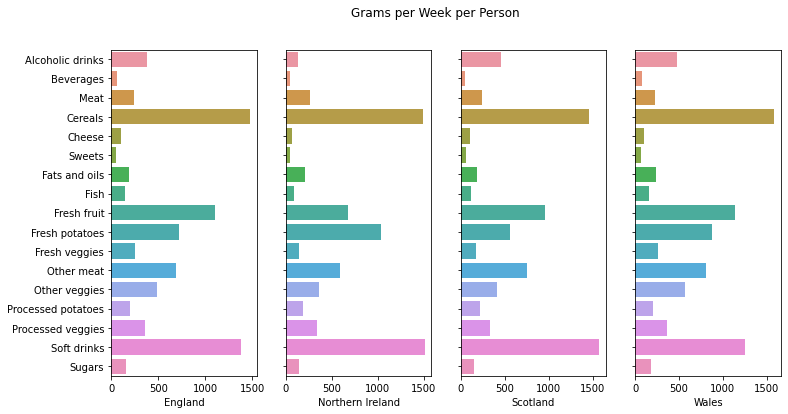

In [3]:
prods = df['Product']
ctries = df.columns.difference(['Product'])

fig, ax = plt.subplots(1, 4, figsize=(12, 6), sharey=True)
for i in range(len(ctries)):
    sns.barplot(x=ctries[i], y='Product', data=df, ax=ax[i])
    ax[i].set_ylabel('')
fig.suptitle('Grams per Week per Person')

Can you spot the differences between the four countries? If you stare at this graph long enough, well... you'll go crazy. :) Instead we can work with a lower-dimensional representation of this data, say 2 PCs instead of 17 features, and see if that helps.

**Compute the SVD of X.**

In [4]:
# Extract numpy ndarray from DataFrame
X_raw = df[ctries].values.T # n=4, p=17
# Center the data
X = X_raw - np.mean(X_raw, axis=0)
n, p = X.shape
print('X:', X.shape)
# Compute s
s = min(X.shape[0], X.shape[1])
print('s:', s)

X: (4, 17)
s: 4


In [5]:
# Compute SVD
U, S, VT = svd(X, full_matrices=False)
# Inspect SVD components
print('U:', U.shape)
print('Sigma:', S.shape)
print('VT:', VT.shape)

U: (4, 4)
Sigma: (4,)
VT: (4, 17)


**Compute & plot first two right singular vectors.** As discussed above, we take the first two rows of $V^T$ here, as these are the first two PCs. As simple as that.

In [6]:
# Extract first two singular vectors
v_0 = VT[0, :].T
v_1 = VT[1, :].T
v_s = [v_0, v_1]
print('0th right singular vector:', '\n', v_0, '\n')
print('1st right singular vector:', '\n', v_1)

0th right singular vector: 
 [-0.46396817 -0.02618776  0.04792763 -0.04770286 -0.05695538 -0.0296502
 -0.00519362 -0.08441498 -0.6326409   0.40140206 -0.15184994 -0.25891666
 -0.24359373 -0.02688623 -0.03648827  0.23224414 -0.03762098] 

1st right singular vector: 
 [-0.11353652  0.03056054 -0.01391582  0.21259968 -0.01601285 -0.00594992
  0.09538866  0.05075495  0.17774074  0.71501708  0.14490027  0.01533114
  0.22545092 -0.04285076  0.0454518  -0.55512431  0.0430217 ]


Each right singular vector is of length $p=17$. Each entry in each vector $v_k$ tells us the magnitude each product has on that axis. We can inspect the absolute numbers to see which products have the greatest magnitude.

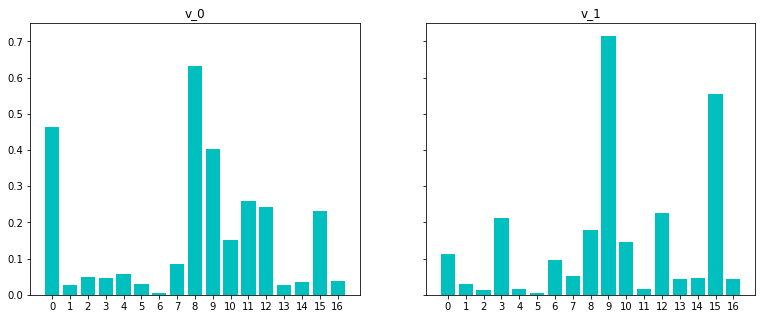

In [7]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(13,5), sharey=True, sharex=True)
for i in range(2):
    ax[i].bar(np.arange(v_s[i].shape[0]), height=np.absolute(v_s[i]), color='c')
    ax[i].set_xticks(range(len(prods)))
    ax[i].set_title(f'v_{i}')

In case of $v_0$ the 0th, 8th and 9th entries carry the greatest magnitude. In case of $v_1$ it's the 9th and 15th entries. By looking back at the data we can tell which products these correspond to.

In [8]:
print('Entries in v_0 with the greatest magnitude:\n')
print(prods[[0, 8, 9]], '/n')

print('\nEntries in v_1 with the greatest magnitude:\n')
print(prods[[9, 15]], '\n')

Entries in v_0 with the greatest magnitude:

0    Alcoholic drinks
8         Fresh fruit
9      Fresh potatoes
Name: Product, dtype: object /n

Entries in v_1 with the greatest magnitude:

9     Fresh potatoes
15       Soft drinks
Name: Product, dtype: object 



Finally, we can take the 17-dimensional data and project it onto the 2-dimensional subspace defined by the first two PCs.

Text(0, 0.5, 'X projected onto v_1 (1st PC)')

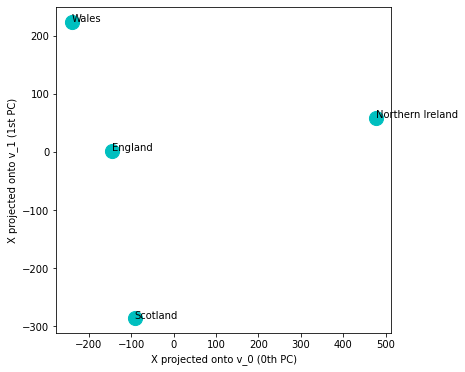

In [9]:
# Project into 2D
X_proj = X.dot(VT[0:2, :].T)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(X_proj[:, 0], X_proj[:, 1], color='c', s=200)
for x_0, x_1, c in zip(X_proj[:, 0], X_proj[:, 1], ctries):
    plt.annotate(c, xy=(x_0, x_1))
plt.xlabel('X projected onto v_0 (0th PC)')
plt.ylabel('X projected onto v_1 (1st PC)')

**Outcome.** By plotting using the first two right singular vectors, ($v_0, v_1)$, we can see clearly that Northern Ireland is quite different from the other three countries in the UK.

# Demo No. 2: Image compression

When we compress an image we end up with a lower-resolution equivalent of the original. If done well, i.e. with a low relative error, the compressed representation might be deceivingly hard to distinguish from the original - at least for the human eye. And, even though they are not identical, the low-resolution compression might be equally usable and, because it's considerably smaller, saves computational resources.

**Using SVD for compression.** If we represent an image as a real-valued matrix $X \in \mathbb{R}^{n \times p}$, then we can approximate $X$ with its $k$-truncated SVD, i.e. $(U_k, \Sigma_k, V_k^T)$ for $0<k<s$. Recall that $s = \min(n, p)$. If the size of its representation, $\tilde{X}$, is lower than the original, then we have compressed $X$.

The squared error of the compressed representation, measured in the Frobenius norm, is given by the sum of the trailing singular values, namely

$$
  \|X - U_k \Sigma_k V_k^T\|_F^2 = \sigma_{k}^2 + \sigma_{k+1}^2 + \cdots + \sigma_{s-1}^2
  .
$$

Consequently, the _relative_ error, can be measured as

$$
  \dfrac{\|X - U_k \Sigma_k V_k^T\|_F}
        {\|X\|_F}
        .
$$

$\|X\|_F$ is the Frobenius norm of $X$ which is given by the sum of all singular values; the diagonal entries of $\Sigma$.

**Display original image.** I took one image from today's "NASA Image of the Day" of a solar solar eclipse visible in Antarctica on Dec. 4, 2021. https://www.nasa.gov/multimedia/imagegallery/iotd.html

In [ ]:
from PIL import Image
img_raw = Image.open('data/epic_1b_20211204075803.png', 'r').convert('L')
img = np.asarray(img_raw)
plt.figure(figsize=(6,6))
plt.imshow(img, interpolation='nearest', cmap='gray')

**Compress via SVD.** Say we want to compress using the 15 trailing singular values, i.e. $k=15$, then the relative reconstruction error is 16.4%.

In [ ]:
# Compute the SVD of the image
U, S, VT = svd(img, full_matrices=False)

In [ ]:
# Get the k-th truncation of U and VT
k = 15
Uk = U[:, :k]
VkT = VT[:k, :]
print('Uk:', Uk.shape)
print('S:', S.shape)
print('VkT:', VkT.shape)

In [ ]:
# Compute relative reconstruction error
err = np.sqrt(np.sum(np.square(S[k:]))) # trailing k singular values
norm = np.sqrt(np.sum(np.square(S)))
rel_err = err / norm
print('% .3f' % rel_err)

**Viz original v compressed representation.**

In [ ]:
# Reconstruct compressed image
img_comp = Uk @ np.diag(S[:k]) @ VkT # first k singular values

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img, interpolation='nearest', cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(img_comp, interpolation='nearest', cmap='gray')
ax[1].set_title('Compressed Representation')

**Outcome.** Using the fifteen highest singular values, opposite to using all 2,048 of them, we lose only about 16% of the original image. Depending on the application we might want to go for a lower relative reconstruction error.